In [7]:
from typing import Dict

import numpy as np
import pandas as pd
from postprocess.general_purpose import open_reduced_dataset
from products.snow_cover_product import VIIRSMeteoFrancePrototype,VNP10A1,VJ110A1, MOD10A1
from reductions.statistics_base import EvaluationVsHighResBase
from winter_year import WinterYear
import xarray as xr
from xarray.groupers import BinGrouper

wy = WinterYear(2023, 2024)
analysis_folder = (
    "/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_6_modis/"
)
product_list = [MOD10A1(), VNP10A1()]


analyses_dict_confusion= {}
for product in product_list:
    analyses_dict_confusion.update({product.name: open_reduced_dataset(product=product, analysis_folder=analysis_folder, analysis_type='confusion_table')}) 


analyses_dict_uncertainty= {}
for product in product_list:
    analyses_dict_uncertainty.update({product.name: open_reduced_dataset(product=product, analysis_folder=analysis_folder, analysis_type='uncertainty')}) 

def sel_evaluation_domain(analyses_dict: Dict[str, xr.Dataset]) ->Dict[str, xr.Dataset]:

    selection_dict={}
    for k, v in analyses_dict.items():
        if 'sensor_zenith_bins' not in v.sizes:
            selection_dict .update({
                k: v.expand_dims({'sensor_zenith_bins': 5})
                })
        else:
            selection_dict.update({k:v})

    selection_dict = {
        k: v.sel(
            time=slice("2023-11", "2024-06"),
            altitude_bins=slice(900, None),
            ref_bins=slice(0, 101),
            slope_bins=slice(None, 60),
            sensor_zenith_bins=slice(None,80)
        )
        for k, v in selection_dict.items()
    }

    selection_dict = {
        k: v.assign_coords(
            {
                "aspect_bins": pd.CategoricalIndex(
                    data=EvaluationVsHighResBase.aspect_bins().labels,
                    categories=EvaluationVsHighResBase.aspect_bins().labels,
                    ordered=True,
                ),
                "forest_mask_bins": ["Open", "Forest"],
                "slope_bins": np.array(["[0-10]", "[11-30]", ">30"], dtype=str),
            }
        )
        for k, v in selection_dict.items()
    }

    selection_dict = {
        k: v.rename(
            {"aspect_bins": "Aspect", "forest_mask_bins": "Landcover", "slope_bins": "Slope [°]"}
        )
        for k, v in selection_dict.items()
    }

    return selection_dict



metrics_dict_conf = sel_evaluation_domain(analyses_dict=analyses_dict_confusion)
metrics_dict_conf = {k:v.groupby(ref_bins=BinGrouper(bins=[-1,0,99,100], labels=["0", "[1-99]", "100"])).sum().rename({"ref_bins_bins": "Ref FSC [%]"}) for k,v in metrics_dict_conf.items()}
metrics_dict_unc = sel_evaluation_domain(analyses_dict=analyses_dict_uncertainty)
metrics_dict_unc = {k:v.sum(dim=( 'time')).assign_coords(ref_bins=["0", "[1-15]","[16-30]", "[31-45]","[46-60]", "[61-75]","[76-90]","[91-99]", "100"]).rename({"ref_bins": "Ref FSC [%]"}) for k,v in metrics_dict_unc.items()}

/home/imperatoren/miniconda3/envs/viirs_env/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Noto Sans.
  func(*args, **kwargs)
/home/imperatoren/miniconda3/envs/viirs_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Noto Sans.
  fig.canvas.print_figure(bytes_io, **kw)


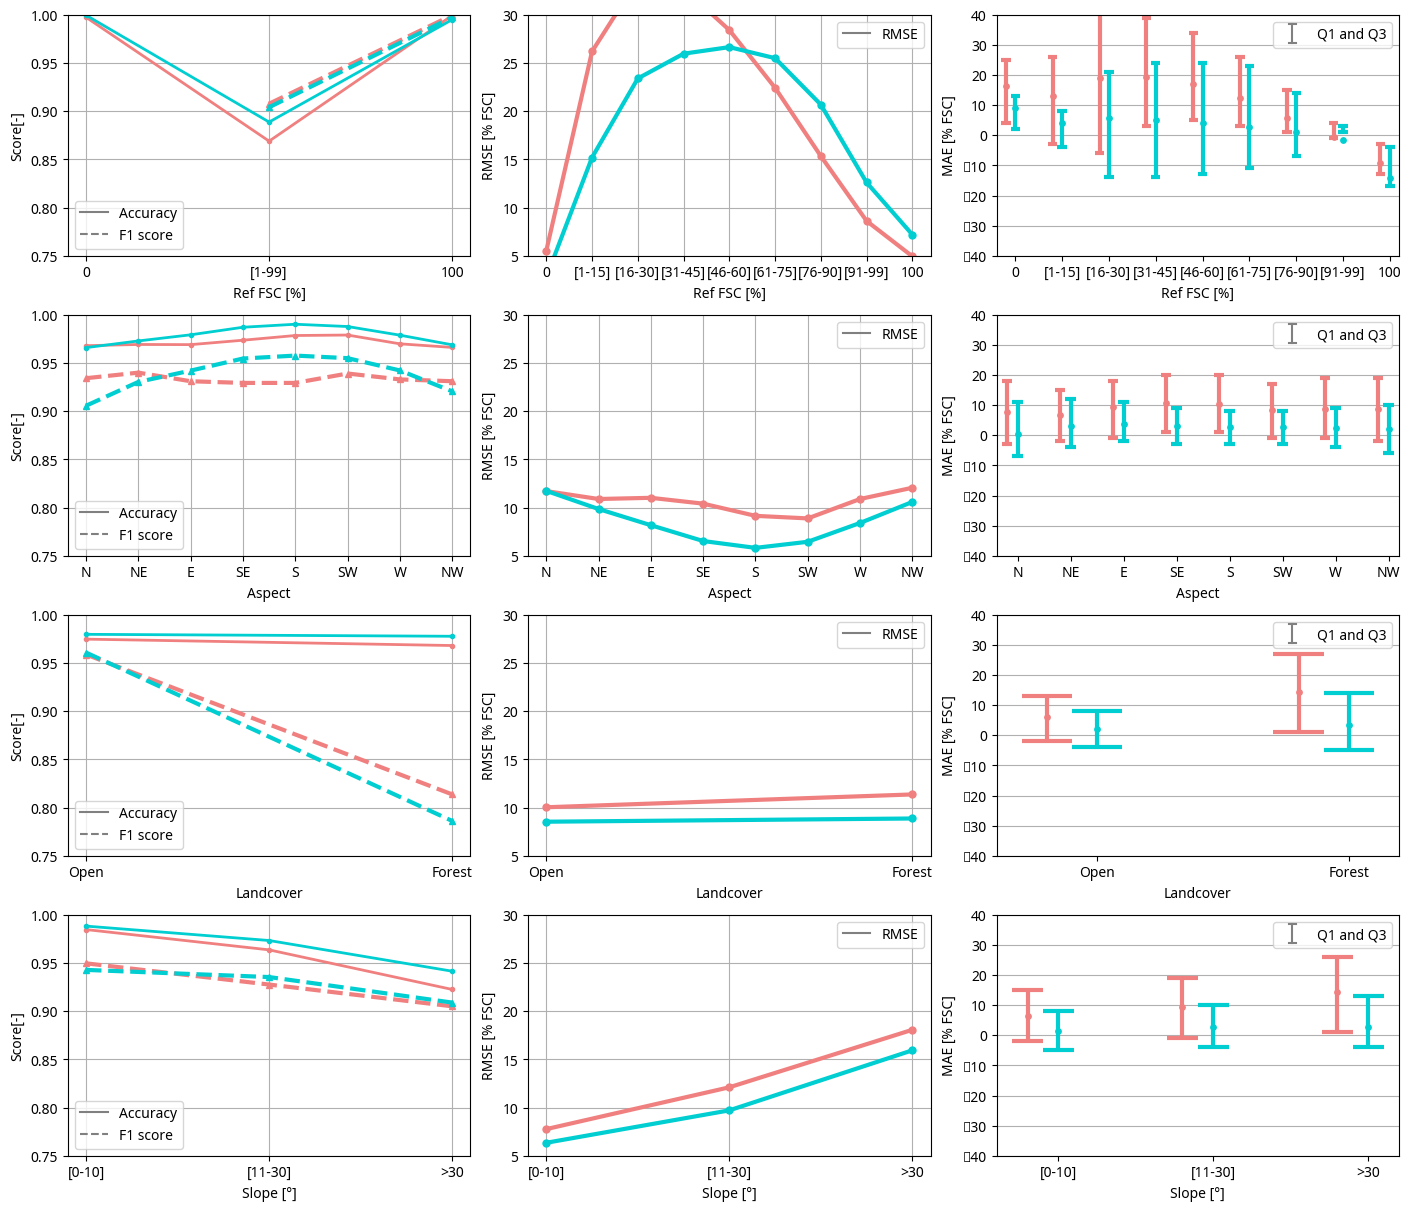

In [8]:
from typing import List
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from postprocess.error_distribution import histograms_to_distribution, line_plot_rmse, plot_custom_spans
from postprocess.skill_scores import line_plot_accuracy_f1_score
from products.plot_settings import PRODUCT_PLOT_COLORS, PRODUCT_PLOT_NAMES
import matplotlib.patches as mpatches


def plot_product_legend(metrics_dict: Dict[str, xr.Dataset],legend_ax: Axes):
    custom_leg = [
            mpatches.Patch(color=PRODUCT_PLOT_COLORS[product_name], label=PRODUCT_PLOT_NAMES[product_name])
            for product_name in metrics_dict
        ]
        
    product_legend =legend_ax.legend(handles=custom_leg, loc='best')
    legend_ax.add_artist(product_legend)

def plot_one_var_analysis(metrics_dict_conf: Dict[str, xr.Dataset], metrics_dict_unc: Dict[str, xr.Dataset], analysis_var:str, axs: List[Axes]):

    line_plot_accuracy_f1_score(metrics_dict_conf, analysis_var=analysis_var,ax=axs[0])
    line_plot_rmse(metrics_dict_unc, analysis_var=analysis_var,ax=axs[1])
    plot_custom_spans(metrics_dict_unc=metrics_dict_unc, analysis_var=analysis_var, ax=axs[2])
def plot_grid(metrics_dict_conf: Dict[str, xr.Dataset], metrics_dict_unc: Dict[str, xr.Dataset], params_list:List[str], axs: List[Axes]):
    for i, var in enumerate(params_list):
        plot_one_var_analysis(metrics_dict_conf, metrics_dict_unc, var,axs[i])


plt.style.use('default')
plt.rcParams["font.family"] = "Noto Sans"
params = [ "Ref FSC [%]", "Aspect", "Landcover", "Slope [°]"] 
fig, axs = plt.subplots(len(params), 3, figsize=(14,3  * len(params)), layout="constrained")
plot_grid(metrics_dict_conf=metrics_dict_conf, metrics_dict_unc=metrics_dict_unc, params_list=params, axs=axs)

In [1]:
import numpy as np
from postprocess.general_purpose import open_reduced_dataset
from postprocess.general_purpose import open_reduced_dataset_completeness
from products.snow_cover_product import VNP10A1, MOD10A1
import xarray as xr
from matplotlib import pyplot as plt
from postprocess.error_distribution import histograms_to_biais_rmse

analysis_type = "completeness"
analysis_folder = (
    "/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_6_modis/"
)

product_list = [ VNP10A1(),  MOD10A1()]



analyses_dict_uncertainty= {}
for product in product_list:
    analyses_dict_uncertainty.update({product.name: open_reduced_dataset(product=product, analysis_folder=analysis_folder, analysis_type='uncertainty')}) 

analyses_dict_completeness= {}
for product in product_list:
    analyses_dict_completeness.update({product.name: open_reduced_dataset_completeness(product=product, analysis_folder=analysis_folder, analysis_type='completeness')}) 

metrics_dict_completeness = {k:v.sel(time=slice('2023-11', '2024-06')) for k,v in analyses_dict_completeness.items()}



metrics_dict_unc = {k:v.resample({"time": "1ME"}).sum(dim="time") for k,v in analyses_dict_uncertainty.items()}
metrics_dict_unc = {k:v.groupby("time").map(histograms_to_biais_rmse) for k,v in metrics_dict_unc.items()}

In [7]:

from matplotlib import font_manager, patches, ticker
from products.plot_settings import NASA_L3_MODIS_TERRA_VAR_NAME, NASA_L3_SNPP_VAR_NAME
from typing import Dict, List
from typing import List
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from postprocess.error_distribution import histograms_to_distribution, line_plot_rmse, plot_custom_spans
from postprocess.skill_scores import line_plot_accuracy_f1_score
from products.plot_settings import PRODUCT_PLOT_COLORS, PRODUCT_PLOT_NAMES
import matplotlib.patches as mpatches

def annual_area_fancy_plot(
    metrics_dict_completeness: Dict[str, xr.Dataset],
    metrics_dict_uncertainty: Dict[str, xr.Dataset],
    axs: List[Axes] | None = None,
):
    if len(metrics_dict_completeness) > 1:
        common_days = np.intersect1d(*[v.coords["time"] for v in metrics_dict_completeness.values()][:2])

    if len(metrics_dict_completeness) > 2:
        for v in metrics_dict_completeness.values():
            common_days = np.intersect1d(common_days, v.coords["time"])
    if axs is None:
        _, axs = plt.subplots(4, 1, figsize=(10, 6), sharex=True, layout="constrained")

    [ax.set_ylabel("Area [km²]") for ax in axs[:1]]
    axs[1].set_ylabel("RMSE [\% FSC]")
    axs[2].set_ylabel("Bias [\% FSC]")
    custom_leg = [
        patches.Patch(color=PRODUCT_PLOT_COLORS[product_name], label=PRODUCT_PLOT_NAMES[product_name])
        for product_name in metrics_dict_completeness
    ]
    product_legend = axs[0].legend(handles=custom_leg, loc=[0.8, 0.45])
    axs[0].add_artist(product_legend)
    old_snow_cover=0
    for product in metrics_dict_completeness:
        metrics_dict_completeness[product] = metrics_dict_completeness[product].sel(time=common_days)
        product_monthly_averages = (
            metrics_dict_completeness[product].resample({"time": "1ME"}).mean(dim="time").data_vars["surface"] * 1e-6
        )

        snow_cover = product_monthly_averages.sel(class_name="snow_cover")
        axs[0].fill_between(
            np.arange(product_monthly_averages.sizes["time"]),
            snow_cover,
            old_snow_cover,
            alpha=0.5,
            color=PRODUCT_PLOT_COLORS[product],
        )
        old_snow_cover = snow_cover
        axs[1].plot(
            np.arange(product_monthly_averages.sizes["time"]),
            metrics_dict_uncertainty[product].rmse,
            '^-',
            color=PRODUCT_PLOT_COLORS[product],
            lw=2,
        )
        axs[2].plot(
            np.arange(product_monthly_averages.sizes["time"]),
            metrics_dict_uncertainty[product].biais,
            '^-',
            color=PRODUCT_PLOT_COLORS[product],
            lw=2,
        )
    axs[0].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0e}"))
    axs[1].set_ylim(0, 20)
    axs[2].set_ylim(-5, 5)
    axs[1].grid()
    axs[2].grid()
    axs[2].set_xticks(np.arange(product_monthly_averages.sizes["time"]))
    axs[2].set_xticklabels(product_monthly_averages.coords["time"].to_dataframe().index.strftime("%B"))
    axs[0].set_title("Snow cover")
    # axs[1].set_title("No snow")
    # axs[2].set_title("Clouds")
    axs[1].set_title("RMSE")
    axs[2].set_title("Bias")


<>:27: SyntaxWarning: invalid escape sequence '\%'
<>:28: SyntaxWarning: invalid escape sequence '\%'
<>:27: SyntaxWarning: invalid escape sequence '\%'
<>:28: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_64358/2002909736.py:27: SyntaxWarning: invalid escape sequence '\%'
  axs[1].set_ylabel("RMSE [\% FSC]")
/tmp/ipykernel_64358/2002909736.py:28: SyntaxWarning: invalid escape sequence '\%'
  axs[2].set_ylabel("Bias [\% FSC]")


<Figure size 640x480 with 0 Axes>

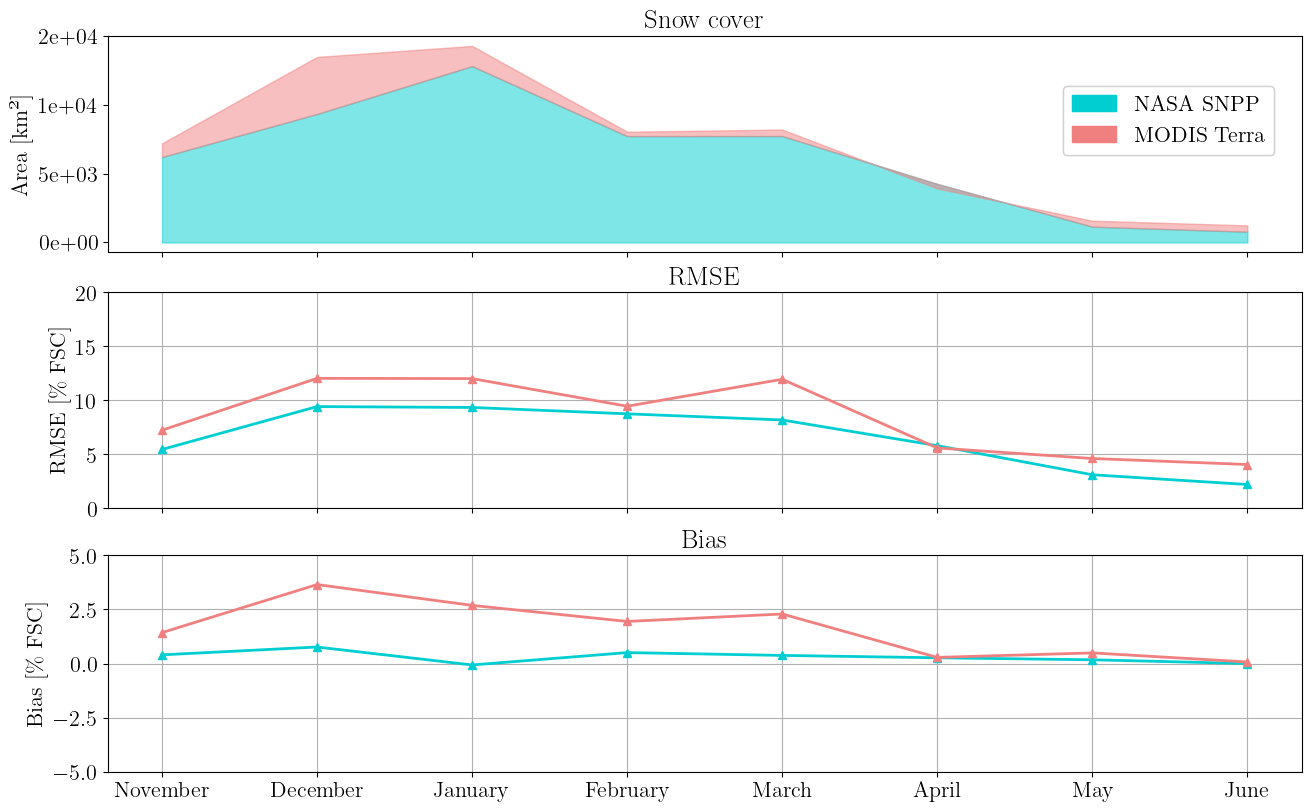

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

# plt.rcParams["font.family"] = "Noto Sans"
# font = {'family' : 'Sans Serif',
#         'weight' : 'normal',
#         'size'   : 18}
# matplotlib.rc('font', **font)
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 16
})

plt.subplots_adjust(bottom=0.18)
fig, axs = plt.subplots(3, 1, figsize=(13, 8), sharex=True, layout="constrained")
# fig.suptitle("Average daily surface mapped per month")
annual_area_fancy_plot(metrics_dict_completeness=metrics_dict_completeness,metrics_dict_uncertainty=metrics_dict_unc, axs=axs)
fig.savefig('/home/imperatoren/work/VIIRS_S2_comparison/article/illustrations/modis.eps', format='eps',bbox_inches='tight')
